In [184]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation, FFMpegWriter
from scipy.signal import hilbert
import matplotlib.colors
from nilearn import plotting
import scipy.linalg as la

In [185]:
data_frame_ = pd.read_csv("schaefer_200_tian-subcortex_16.csv", header=0)
data_frame_ = data_frame_.iloc[:200, 2:5]  # Select only the first three columns
pos = data_frame_.values  # Convert to NumPy array

In [186]:
# 1. Read the CSV into a DataFrame
#    - header=None: treat all rows as data
#    - usecols=range(216): read exactly 216 columns (adjust if needed)

# 1. Read the full 216×216 CSV, forcing float parsing so "0.00000E00" → 0.0
df = pd.read_csv(
    'hcp_MEG_connectomes/102816_sc.csv',
    header=0,               # no header row
    usecols=range(216),        # read cols 0–215
    dtype=float                # parse everything as float
)

# 2. Slice out top-left 200×200
sub = df.iloc[:200, :200]

# 3. Convert any non-zero to 1, zeros remain 0
binary = (sub != 0).astype(int)

# 4. Convert to NumPy array
A_bin = binary.values  # shape (200, 200), dtype=int

# 6. Compute all eigenvalues and pick the largest (by real part)
eigenvalues = np.linalg.eigvals(A_bin)
max_eig = np.max(np.real(eigenvalues))
A = A_bin # normalize by largest eigenvalue

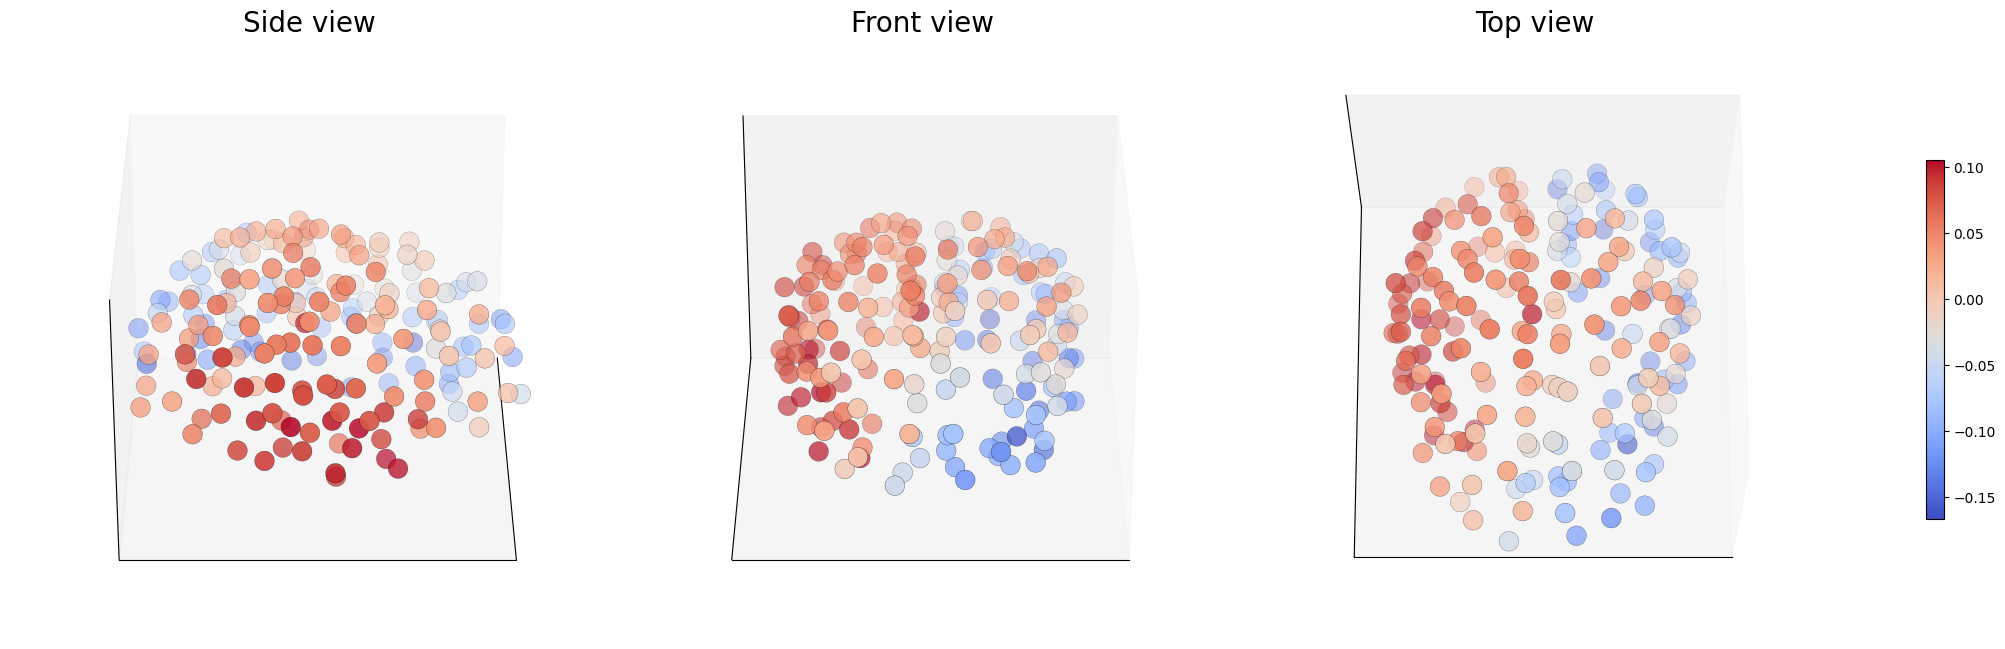

In [ ]:
def sym_normalized_laplacian(A):
    """
    Compute the symmetric normalized Laplacian L_sym = I - D^{-1/2} A D^{-1/2}
    for an undirected graph with adjacency matrix A.
    """
    # Degree matrix
    degrees = np.sum(A, axis=1)
    D = np.diag(degrees)
    
    # Inverse sqrt of D (handle zero degrees)
    with np.errstate(divide='ignore'):
        inv_sqrt_degrees = 1.0 / np.sqrt(degrees)
    inv_sqrt_degrees[np.isinf(inv_sqrt_degrees)] = 0.0
    D_inv_sqrt = np.diag(inv_sqrt_degrees)
    
    # Symmetric normalized Laplacian
    L_sym = np.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
    return L_sym

L_sym = sym_normalized_laplacian(A)
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(L_sym)

# L_sym from before, then
vals, vecs = np.linalg.eigh(L_sym)
idx = np.argsort(vals)
vals, vecs = vals[idx], vecs[:,idx]

n=2

lam, v = vals[n], eigenvectors[:,n]

# Shared color limits

# ───── set up figure with 3 subplots ─────
fig, axes = plt.subplots(1, 3, figsize=(20,8),
                         subplot_kw={'projection': '3d'}, layout='compressed')

angles = [0, 90, 90]
elev =[30, 30, 70]

scats = []
for ax, angles, elev_, title in zip(axes, angles, elev, ['Side view', 'Front view', 'Top view']):
    scat = ax.scatter(
        pos[:,0], pos[:,1], pos[:,2],
        c=v,
        cmap='coolwarm', vmin=v.min(), vmax=v.max(),
        s=200, edgecolor='k', lw=0.2
    )
    ax.set_title(f"{title}", fontsize=20)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.grid(True)
    # fix aspect ratio
    mr = (pos.max(axis=0) - pos.min(axis=0)).max() / 2
    mid = pos.mean(axis=0)
    ax.set_xlim(mid[0]-mr, mid[0]+mr)
    ax.set_ylim(mid[1]-mr, mid[1]+mr)
    ax.set_zlim(mid[2]-mr, mid[2]+mr)
    ax.view_init(elev=elev_, azim=angles)

    scats.append(scat)

# one shared colorbar on the right
plt.colorbar(scats[0], ax=axes, shrink=0.6, pad=0.05)


In [ ]:
import os

folder_path = 'hcp_MEG_connectomes'

# List everything in the folder...
all_entries = os.listdir(folder_path)

# …and filter to keep only files
file_names = [f for f in all_entries if os.path.isfile(os.path.join(folder_path, f))]

# Convert to a NumPy array
file_array = np.array(file_names)

['191437_sc.csv' '175540_sc.csv' '108323_sc.csv' '105923_sc.csv'
 '187547_sc.csv' '156334_sc.csv' '353740_sc.csv' '113922_sc.csv'
 '898176_sc.csv' '104012_sc.csv' '512835_sc.csv' '214524_sc.csv'
 '169040_sc.csv' '358144_sc.csv' '706040_sc.csv' '181232_sc.csv'
 '406836_sc.csv' '257845_sc.csv' '175237_sc.csv' '212318_sc.csv'
 '877168_sc.csv' '581450_sc.csv' '679770_sc.csv' '158136_sc.csv'
 '223929_sc.csv' '233326_sc.csv' '116726_sc.csv' '599671_sc.csv'
 '917255_sc.csv' '891667_sc.csv' '725751_sc.csv' '667056_sc.csv'
 '735148_sc.csv' '177746_sc.csv' '133019_sc.csv' '660951_sc.csv'
 '783462_sc.csv' '112920_sc.csv' '185442_sc.csv' '665254_sc.csv'
 '293748_sc.csv' '204521_sc.csv' '153732_sc.csv' '106521_sc.csv'
 '568963_sc.csv' '221319_sc.csv' '248339_sc.csv' '164636_sc.csv'
 '433839_sc.csv' '149741_sc.csv' '601127_sc.csv' '166438_sc.csv'
 '825048_sc.csv' '189349_sc.csv' '352132_sc.csv' '154532_sc.csv'
 '352738_sc.csv' '283543_sc.csv' '287248_sc.csv' '146129_sc.csv'
 '174841_sc.csv' '191841_

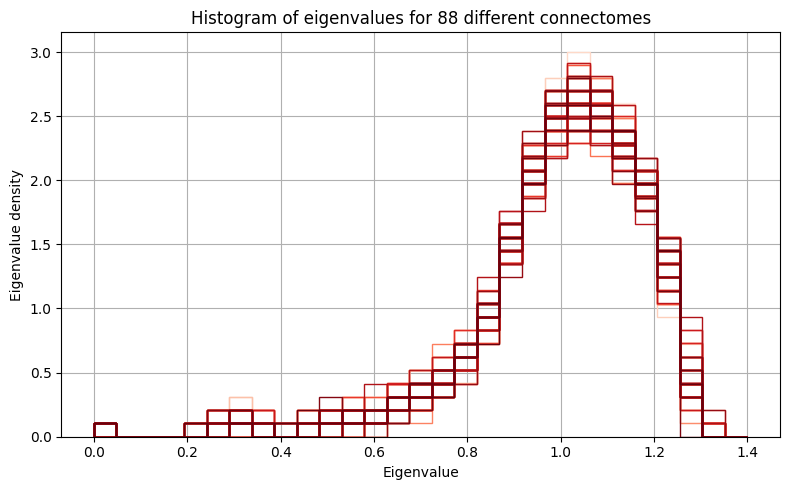

In [ ]:
fig=plt.figure(figsize=(8,5)) #Size of the plot
ax=fig.add_subplot(111)

cmap = plt.get_cmap("Reds", len(file_array))
    
    # 2) sample it at integers [0..N-1]
colors = cmap(np.arange(len(file_array)))

edges = np.linspace(0, 1.4, 30)

for i in range(len(file_array)):
    # Read the CSV file
    df = pd.read_csv(
    'hcp_MEG_connectomes/'+ file_array[i],
    header=0,               # no header row
    usecols=range(216),        # read cols 0–215
    dtype=float )               # parse everything as float
    
    # Slice out top-left 200×200
    sub = df.iloc[:200, :200]
    
    # Convert any non-zero to 1, zeros remain 0
    binary = (sub != 0).astype(int)
    
    # Convert to NumPy array
    A_bin = binary.values  # shape (200, 200), dtype=int
    
    # Compute all eigenvalues and pick the largest (by real part)
    eigenvalues = np.linalg.eigvals(A_bin)
    max_eig = np.max(np.real(eigenvalues))
    
    # Normalize by largest eigenvalue
    A = A_bin / max_eig
    
    L_sym = sym_normalized_laplacian(A)
    
    vals, vecs = np.linalg.eigh(L_sym)
    vals = vals[0]
    idx = np.argsort(vals)
    vals, vecs = vals[idx], vecs[:,idx]

    plt.hist(vals, bins=edges, density=True, histtype='step', color=colors[i])

plt.xlabel('Eigenvalue')
plt.ylabel('Eigenvalue density')
plt.title('Histogram of eigenvalues for 88 different connectomes')
plt.grid()
plt.tight_layout()
plt.show()

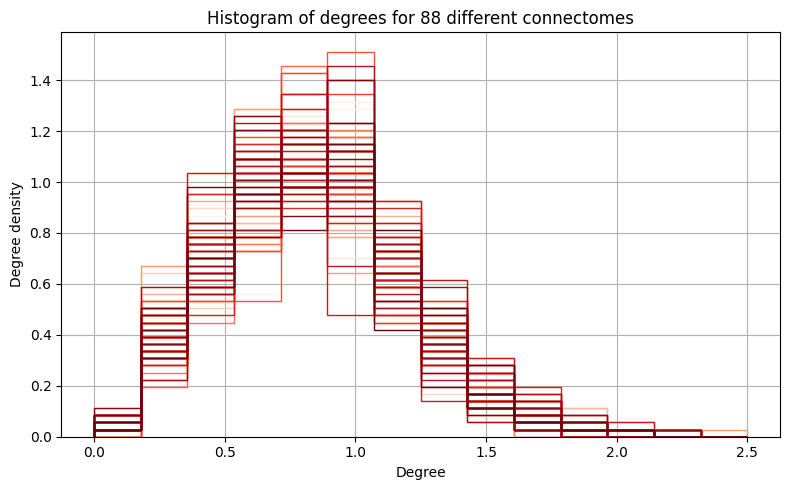

In [240]:
fig=plt.figure(figsize=(8,5)) #Size of the plot
ax=fig.add_subplot(111)

cmap = plt.get_cmap("Reds", len(file_array))
    
    # 2) sample it at integers [0..N-1]
colors = cmap(np.arange(len(file_array)))

edges = np.linspace(0, 2.5, 15)

for i in range(len(file_array)):
    # Read the CSV file
    df = pd.read_csv(
    'hcp_MEG_connectomes/'+ file_array[i],
    header=0,               # no header row
    usecols=range(216),        # read cols 0–215
    dtype=float )               # parse everything as float
    
    # Slice out top-left 200×200
    sub = df.iloc[:200, :200]
    
    # Convert any non-zero to 1, zeros remain 0
    binary = (sub != 0).astype(int)
    
    # Convert to NumPy array
    A_bin = binary.values  # shape (200, 200), dtype=int
    
    # Compute all eigenvalues and pick the largest (by real part)
    eigenvalues = np.linalg.eigvals(A_bin)
    max_eig = np.max(np.real(eigenvalues))
    
    # Normalize by largest eigenvalue
    A = A_bin / max_eig

    plt.hist(np.sum(A, axis=1), bins=edges, density=True, histtype='step', color=colors[i])



# fig=plt.figure(figsize=(8,5)) #Size of the plot
# ax=fig.add_subplot(111)
# plt.hist(np.sum(A, axis=1), bins=20, density=True, histtype='step')
plt.xlabel('Degree')
plt.ylabel('Degree density')
plt.grid()
plt.title(f'Histogram of degrees for {len(file_array)} different connectomes')
plt.tight_layout()
plt.show()